# Fine-Tuning para Detecção de Emoções com FER2013 usando MobileNetV2

In [1]:
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [2]:
# Inicio do treinamento
start_time = time.time()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unrar x /content/drive/MyDrive/NN_HW2_Face_Emotion.rar

Streaming output truncated to the last 5000 lines.
Extracting  TRAIN/fear/image0000285.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000419.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000451.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000473.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000694.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000701.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000777.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000808.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000815.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000842.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0

In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [6]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [7]:
# Configuração do TensorBoard
# Diretório de logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
gpus = tf.config.list_physical_devices("GPU")
print("GPUs disponíveis:", gpus)

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Caminhos
train_dir = './TRAIN'
val_dir = './TUNE'

In [10]:
# Hiperparâmetros
img_size = 128  # MobileNetV2 exige >=96x96
batch_size = 64
num_epochs = 30
num_classes = 8

In [11]:
# Preprocessamento dos dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

In [12]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 8000 images belonging to 8 classes.


In [14]:
# Exibição de classes
print("Classes disponíveis:", train_generator.class_indices)

Classes disponíveis: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


In [15]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 1600 images belonging to 8 classes.


In [16]:
# Carregando o modelo base
base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Congelando os pesos do backbone
base_model.trainable = False

# Cabeçalho personalizado
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [18]:
# Compilando
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Treinamento inicial com backbone congelado
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    callbacks=[early_stop, tensorboard_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 363ms/step - accuracy: 0.1216 - loss: 2.9018 - val_accuracy: 0.1619 - val_loss: 2.2082
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 319ms/step - accuracy: 0.1497 - loss: 2.6258 - val_accuracy: 0.1906 - val_loss: 2.1170
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.1775 - loss: 2.4905 - val_accuracy: 0.2163 - val_loss: 2.0548
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - accuracy: 0.1841 - loss: 2.4216 - val_accuracy: 0.2319 - val_loss: 2.0057
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - accuracy: 0.2185 - loss: 2.3050 - val_accuracy: 0.2450 - val_loss: 1.9721
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - accuracy: 0.2165 - loss: 2.2419 - val_accuracy: 0.2506 - val_loss: 1.9494
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - accuracy: 0.2269 - loss: 2.1969 - val_accuracy: 0.2594 - val_loss: 1.9246
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.2510 - loss: 2

In [20]:
# Salvando o modelo
model.save('mobilenetv2_emotion_finetuned_v4.keras')

In [21]:
# Fim do treinamento
end_time = time.time()

In [22]:
# Cálculo do tempo total em segundos
training_time = end_time - start_time

In [23]:
training_time

1356.0802090168

In [24]:
# Convertendo para horas, minutos e segundos
hours = training_time // 3600
minutes = (training_time % 3600) // 60
seconds = (training_time % 3600) % 60

print(f"Tempo total de treinamento: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Tempo total de treinamento: 0h 22m 36s


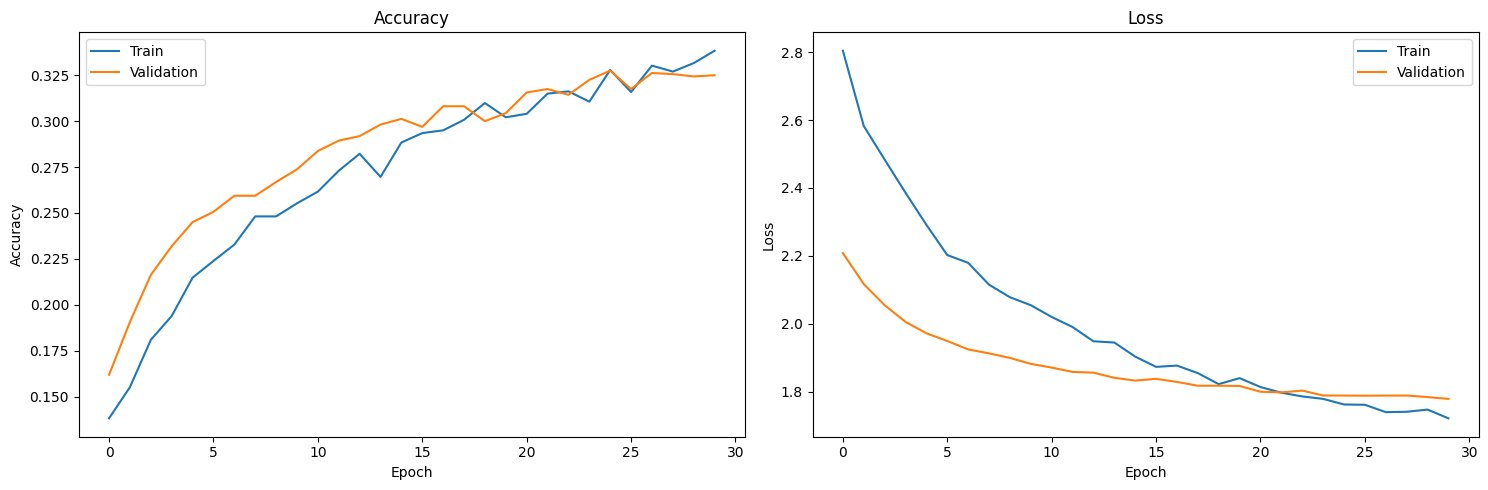

In [25]:
# Função para plotar histórico
def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(history.history['accuracy'], label='Train')
    axs[0].plot(history.history['val_accuracy'], label='Validation')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].plot(history.history['loss'], label='Train')
    axs[1].plot(history.history['val_loss'], label='Validation')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

plot_model_history(history)

In [26]:
# Acurácia final no conjunto de treinamento
train_accuracy = history.history['accuracy'][-1]

# Acurácia final no conjunto de validação
val_accuracy = history.history['val_accuracy'][-1]

print(f"Acurácia no conjunto de treinamento: {train_accuracy * 100:.2f}%")
print(f"Acurácia no conjunto de validação: {val_accuracy * 100:.2f}%")


Acurácia no conjunto de treinamento: 33.84%
Acurácia no conjunto de validação: 32.50%


In [27]:
# Exibir todas as acurácias por epoch
for epoch, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), 1):
    print(f"Epoch {epoch}: Treinamento: {train_acc * 100:.2f}%, Validação: {val_acc * 100:.2f}%")

Epoch 1: Treinamento: 13.81%, Validação: 16.19%
Epoch 2: Treinamento: 15.51%, Validação: 19.06%
Epoch 3: Treinamento: 18.09%, Validação: 21.63%
Epoch 4: Treinamento: 19.39%, Validação: 23.19%
Epoch 5: Treinamento: 21.48%, Validação: 24.50%
Epoch 6: Treinamento: 22.39%, Validação: 25.06%
Epoch 7: Treinamento: 23.27%, Validação: 25.94%
Epoch 8: Treinamento: 24.81%, Validação: 25.94%
Epoch 9: Treinamento: 24.81%, Validação: 26.69%
Epoch 10: Treinamento: 25.53%, Validação: 27.38%
Epoch 11: Treinamento: 26.16%, Validação: 28.37%
Epoch 12: Treinamento: 27.30%, Validação: 28.94%
Epoch 13: Treinamento: 28.22%, Validação: 29.19%
Epoch 14: Treinamento: 26.96%, Validação: 29.81%
Epoch 15: Treinamento: 28.84%, Validação: 30.13%
Epoch 16: Treinamento: 29.35%, Validação: 29.69%
Epoch 17: Treinamento: 29.50%, Validação: 30.81%
Epoch 18: Treinamento: 30.07%, Validação: 30.81%
Epoch 19: Treinamento: 30.99%, Validação: 30.00%
Epoch 20: Treinamento: 30.21%, Validação: 30.44%
Epoch 21: Treinamento: 30.40%

## Visualizando os Métricos no TensorBoard
Para iniciar o TensorBoard, execute o seguinte comando no terminal:

```bash
tensorboard --logdir=logs/fit
```

Depois, acesse o endereço fornecido pelo TensorBoard no navegador para visualizar os gráficos e métricas.

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
%tensorboard --logdir=logs/fit --port=6006

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Salvar os arquivos local

/Logs

In [ ]:
!zip -r /content/logs.zip /content/logs
from google.colab import files
files.download("/content/logs.zip")

/model

In [ ]:
!zip -r /content/mobilenetv2_emotion_finetuned_v2.keras.zip /content/mobilenetv2_emotion_finetuned_v2.keras
from google.colab import files
files.download("/content/mobilenetv2_emotion_finetuned_v2.keras.zip")

  adding: content/mobilenetv2_emotion_finetuned_07-05.keras (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>